### Build, train and deploy a NN model on AWS SageMaker

- Our task is to build, train and deploy a NN using MNIST fashion dataset on AWS SageMaker. 
- MNIST data contains 60,000 small square 28  ×  28 pixel grayscale images of 10 types of clothing, such as shoes, t-shirts, dresses, and more.


Download data 

Using TensorFlow backend.


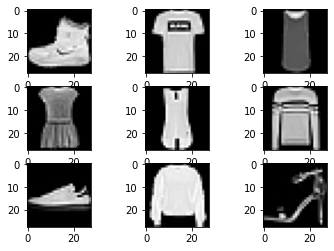

In [1]:
import os
import keras
import numpy as np
from keras.datasets import fashion_mnist
from matplotlib import pyplot
(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

# plot some raw pixel data
for i in range(9):
  
    pyplot.subplot(330 + 1 + i)

    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

pyplot.show()

We create a local directory and save the training and test data seperately

In [7]:
os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_val, label=y_val)

In [8]:
%%sh 
ls -l data

total 53668
-rw-rw-r-- 1 ec2-user ec2-user  7850506 Aug 24 06:24 test.npz
-rw-rw-r-- 1 ec2-user ec2-user 47100506 Aug 24 06:24 training.npz


### Train on AWS SageMaker

- Create session and role permission 

In [9]:
import sagemaker

print(sagemaker.__version__)
sess = sagemaker.Session()
role = sagemaker.get_execution_role()


1.72.0


Train the model on the local instance

In [12]:
from sagemaker.tensorflow import TensorFlow
tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn.py',
                         role = role, 
                         train_instance_count = 1,
                         train_instance_type ='local',
                         framework_version = '1.15',
                         py_version ='py3',
                         script_mode =True,
                         hyperparameters={'epochs':1})
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'


In [13]:
tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmp4t76slhu_algo-1-e4wv4_1 ... 
Attaching to tmp4t76slhu_algo-1-e4wv4_12mdone
algo-1-e4wv4_1  | WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.
algo-1-e4wv4_1  | 
algo-1-e4wv4_1  | 2020-08-24 06:36:43,725 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-e4wv4_1  | 2020-08-24 06:36:43,732 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-e4wv4_1  | 2020-08-24 06:36:45,031 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-e4wv4_1  | 2020-08-24 06:36:45,050 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-e4wv4_1  | 2020-08-24 06:36:45,068 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-e4wv4_1  | 2020-08-24 06:36:45,079 sagema

### Upload the dataset to S3


In [16]:
prefix = 'keras-mnist-fashion'

training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')

test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

print(training_input_path)
print(test_input_path)

s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/training/training.npz
s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/validation/test.npz


### Train with managed instances

Used [managed spot instance](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-spot-instances.html) to save money 

In [17]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, rule_configs

tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.m4.xlarge',
                          framework_version='1.15', 
                          py_version='py3',
                          script_mode=True,
                          train_use_spot_instances=True,        # Use spot instance
                          train_max_run=3600,                    # Max training time
                          train_max_wait=7200,                  # Max training time + spot waiting time
                          rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
                                   Rule.sagemaker(rule_configs.overfit())]
                         )


In [18]:
tf_estimator.fit({'training': training_input_path, 'validation': test_input_path})   

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-24 06:44:36 Starting - Starting the training job...
2020-08-24 06:44:38 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*            Overfit: InProgress        
*
****************************************
......
2020-08-24 06:45:45 Starting - Preparing the instances for training...
2020-08-24 06:46:32 Downloading - Downloading input data...
2020-08-24 06:47:02 Training - Downloading the training image...
2020-08-24 06:47:22 Training - Training image download completed. Training in progress.WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2020-08-24 06:47:23,940 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-08-24 06:47:23,947 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)


### Deploy the model


In [20]:
%%sh
python3 -m pip install --upgrade pip

  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2


In [19]:
import time

tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge', 
                                   endpoint_name=tf_endpoint_name)    

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

### Prediction exercise


Predicted labels are: [3 1 5 1 1 8 4 4 5 0]


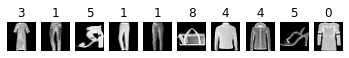

In [21]:
 %matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 10
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_labels = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_labels))

### Delete the endpoint

Remember to delete the endpoint when you are not using to avoid unnecessary surcharge from AWS.

In [25]:
tf_predictor.delete_endpoint()